In [1]:
import os

import pandas as pd
import numpy as np


In [2]:
from mylib.result import Result

In [3]:
result_dir = "results/"

# View result dataframe

### Setup

In [4]:

def full_dataframe_from_results(result):
    
    ###          Continous univariate          ###

    feats = ["raw_amount", "td"]
    metrics = ["ks", "wasser"]


    records = []

    for f in feats:
        for m in metrics:

            d = {"index": f + "-" + m, "measures": f, "metric":m, "value": result.univariate_cont_res[f][m]}


            records.append(d)


    ###          N-Grams          ###

    metrics = ["jsd", "jac", "coverage_r", "coverage_g", "NED"]


    ngram_n_vals = result.ngram_res["code"].keys()

    for n in ngram_n_vals:
        f = f"codes_{n}-grams"

        for m in metrics:
            mean_val = np.mean([v[m] for v in result.ngram_res["code"][n].values()]) 

            d = {"index": f + "_mean-" + m, "measures": f, "metric":m, "value": mean_val}

            records.append(d)



    for n in ngram_n_vals:
        f = f"tcode_{n}-grams"

        for m in metrics:
            val = result.ngram_res["tcode"][n][m]

            d = {"index": f + "_mean-" + m, "measures": f, "metric":m, "value": val}

            records.append(d)


    for n in ngram_n_vals:
        f = f"dates_{n}-grams"

        for m in metrics:
            mean_val = np.mean([v[m] for v in result.ngram_res["date"][n].values()]) 

            d = {"index": f + "_mean-" + m, "measures": f, "metric":m, "value": mean_val}

            records.append(d)



    ###          Categorical + amount          ###


    metrics = ["wasser", "ks"]
    cont_fields = ["raw_amount"]



    for m in metrics:
        for cf in cont_fields: 

            d = result.amount_codes_res["code"]

            # this is mean over code, of the distance between the joint distributions 
            mean_val =  np.mean([(v[cf][m + "_r"] + v[cf][m + "_g"])/2. for v in d.values()])

            record = {"index": "joint-codes-" + cf + "_" + m, "measures": "codes, " + cf , "metric":m, "value": mean_val}

            records.append(record)




    for m in metrics:
        for cf in cont_fields: 

            d = result.amount_codes_res["tcode"][cf]

            # val = (d[m + "_r"] + d[m + "_g"])/2.
            val = d[m + "_r"] # just use expectation over real!

            d = {"index": "*r-joint-tcode-" + cf+ "_" + m, "measures": "tcode, " + cf, "metric":m, "value": val}

            records.append(d)



    ###          2 Categorical + amounts          ###

    cat_metrics = ['jsd', 'jac', 'coverage_r',  'coverage_g']
    con_metrics = ['wasser', "ks"]
    cont_fields = ["raw_amount"]


    #####        Codes        #####

    d = result.amount_code_date_res["code"]

    res_d = {}

    for m in cat_metrics:
        vals = []
        res_d[m] = vals
        for field1 in d.keys():
            vals.append([])
            for field2 in d[field1].keys():
                vals[-1].append(d[field1][field2][m])



    for m in cat_metrics:
        mean_val =  np.mean(res_d[m])

        record = {"index": "joint-codes-dates_" + m, "measures": "codes, dates" , "metric":m, "value": mean_val}

        records.append(record)


    ## cont metrics

    # res_d = {}

    for m in con_metrics:

        vals = []
        vals_r = []
    #     res_d[m] = vals
        for field1 in d.keys():
            vals.append([])
            vals_r.append([])
            for field2 in d[field1].keys():

                cmr = d[field1][field2]["cont_metric_results"]["raw_amount"]
                mean_val = (cmr[m + "_r"] + cmr[m + "_g"])/2. # mean between 'expectation over r, expectation over g'

                vals[-1].append(mean_val)
                vals_r[-1].append(cmr[m + "_r"])

        mean_val = np.mean(vals)

        record = {"index": "joint-codes-dates-amt_" + m, "measures": "codes, dates, amt" , "metric":m, "value": mean_val}
        records.append(record)
        
        
        # for expectation wrt R, not ave
        mean_val = np.mean(vals_r)

        record = {"index": "*r-joint-codes-dates-amt_" + m, "measures": "codes, dates, amt" , "metric":m, "value": mean_val}
        records.append(record)





    #####        Tcode        #####
    d = result.amount_code_date_res["tcode"]

    res_d = {}

    for m in cat_metrics:
        vals = []
        res_d[m] = vals
        for field1 in d.keys():
            vals.append(d[field1][m])

    for m in cat_metrics:
        mean_val =  np.mean(res_d[m])

        record = {"index": "joint-tcodes-dates_" + m, "measures": "tcode, dates" , "metric":m, "value": mean_val}

        records.append(record)    




    ## cont metrics


    for m in con_metrics:

        vals = []
        for field1 in d.keys():


            cmr = d[field1]["cont_metric_results"]["raw_amount"]
            # mean_val = (cmr[m + "_r"] + cmr[m + "_g"])/2. # mean between 'expectation over r, expectation over g'
            mean_val = cmr[m + "_r"]  # not a mean, just expectation over real!
            

            vals.append(mean_val)

        mean_val = np.mean(vals)
        record = {"index": "*r-joint-tcode-dates-amt_" + m, "measures": "tcode, dates, amt" , "metric":m, "value": mean_val}
        records.append(record)


        
    record = {"index": "gen_fname", "measures": "name" , "metric":"None", "value": result.gen_df_name}
    records.append(record)
    
    record = {"index": "real_fname", "measures": "name" , "metric":"None", "value": result.real_df_name}
    records.append(record)

    return pd.DataFrame.from_records(records)


### Set most important quality metrics

In [5]:
basic_qual_metrics = """
raw_amount-wasser
td-wasser
codes_1-grams_mean-jsd
codes_3-grams_mean-jsd
tcode_1-grams_mean-jsd
tcode_3-grams_mean-jsd
dates_1-grams_mean-jsd
dates_3-grams_mean-jsd
joint-codes-raw_amount_wasser
joint-tcode-raw_amount_wasser
joint-codes-dates_jsd
joint-tcode-dates_jsd
joint-tcode-dates-amt_wasser
""".split()

basic_qual_metrics

['raw_amount-wasser',
 'td-wasser',
 'codes_1-grams_mean-jsd',
 'codes_3-grams_mean-jsd',
 'tcode_1-grams_mean-jsd',
 'tcode_3-grams_mean-jsd',
 'dates_1-grams_mean-jsd',
 'dates_3-grams_mean-jsd',
 'joint-codes-raw_amount_wasser',
 'joint-tcode-raw_amount_wasser',
 'joint-codes-dates_jsd',
 'joint-tcode-dates_jsd',
 'joint-tcode-dates-amt_wasser']

# Combine results for all datasets

In [6]:
dfs = []

for fname in os.listdir(result_dir):
    
    if not ".result" in fname:
        continue 
        
        
    r = Result.load(os.path.join(result_dir, fname))
    
    dfs.append(full_dataframe_from_results(r))

In [7]:
r

In [8]:
#     #####        Tcode        #####
#     d = result.amount_code_date_res["tcode"]

#     res_d = {}

#     for m in cat_metrics:
#         vals = []
#         res_d[m] = vals
#         for field1 in d.keys():
#             vals.append(d[field1][m])

#     for m in cat_metrics:
#         mean_val =  np.mean(res_d[m])

#         record = {"index": "joint-tcodes-dates_" + m, "measures": "tcode, dates" , "metric":m, "value": mean_val}

#         records.append(record)    



In [9]:
cat_metrics = ['jsd', 'jac', 'coverage_r',  'coverage_g']
con_metrics = ['wasser', "ks"]
cont_fields = ["raw_amount"]

In [10]:
    d = r.amount_code_date_res["tcode"]
    res_d = {}
    for m in cat_metrics:
        vals = []
        res_d[m] = vals
        for field1 in d.keys():
            vals.append(d[field1][m])

# *** here

In [11]:
r.amount_code_date_res["tcode"]

{'day': {'jsd': 0.048653905778387754,
  'entr_r': 3.477820835590428,
  'entr_g': 3.6708007324404184,
  'l1': 0.42082000000000014,
  'l2': 0.08134713147985,
  'jac': 0.06451612903225806,
  'count_r': 58.0,
  'coverage_r': 0.9354838709677419,
  'count_g': 62.0,
  'coverage_g': 1.0,
  'count_max': 62,
  'cont_metric_results': {'amount': {'wasser_r': 315.65036821218905,
    'wasser_g': 287.64892440903947,
    'ks_r': 1.0000000000000002,
    'ks_g': 0.9909600000000003,
    'energy_d_r': 14.257707793119621,
    'energy_d_g': 13.537288609663603},
   'raw_amount': {'wasser_r': 262.1555903956441,
    'wasser_g': 235.21054906944255,
    'ks_r': 0.4202721321459077,
    'ks_g': 0.4180738251443524,
    'energy_d_r': 8.487381242831152,
    'energy_d_g': 8.013647476738873},
   'td': {'wasser_r': 0.8781393592268667,
    'wasser_g': 0.900578368971883,
    'ks_r': 0.23972924683328928,
    'ks_g': 0.23944060534770498,
    'energy_d_r': 0.48757393244131686,
    'energy_d_g': 0.4943890784029523}}},
 'dow':

In [12]:
r.amount_code_date_res["code"]

{'day': {'description': {'jsd': 0.11479671631765637,
   'entr_r': 5.961122742658259,
   'entr_g': 6.42783544969828,
   'l1': 0.7244999999999977,
   'l2': 0.054176828995429374,
   'jac': 0.16303531179564237,
   'count_r': 1132.0,
   'coverage_r': 0.8299120234604106,
   'count_g': 1313.0,
   'coverage_g': 0.9626099706744868,
   'count_max': 1364,
   'cont_metric_results': {'amount': {'wasser_r': 314.9836696947014,
     'wasser_g': 238.84984115184608,
     'ks_r': 0.9995300000000005,
     'ks_g': 0.9549399999999977,
     'energy_d_r': 16.46496479958225,
     'energy_d_g': 14.039236232833405},
    'raw_amount': {'wasser_r': 269.69099113686684,
     'wasser_g': 198.33000227695283,
     'ks_r': 0.6894178527461905,
     'ks_g': 0.6866541179187176,
     'energy_d_r': 11.02860035572672,
     'energy_d_g': 9.149765205079351},
    'td': {'wasser_r': 0.9630481995454672,
     'wasser_g': 0.9821145147527012,
     'ks_r': 0.26435374521185356,
     'ks_g': 0.3051907247370418,
     'energy_d_r': 0.5538

In [13]:
res_d

{'jsd': [0.048653905778387754,
  0.06321069473091434,
  0.02786732652480171,
  0.04410078445784334],
 'jac': [0.06451612903225806,
  0.14285714285714285,
  0.3333333333333333,
  0.03225806451612903],
 'coverage_r': [0.9354838709677419,
  0.8571428571428571,
  0.6666666666666666,
  0.967741935483871],
 'coverage_g': [1.0, 1.0, 1.0, 1.0]}

In [14]:
field1

'dtme'

In [15]:
d[field1]

{'jsd': 0.04410078445784334,
 'entr_r': 3.5219265459491114,
 'entr_g': 3.69006864134068,
 'l1': 0.4344000000000001,
 'l2': 0.08076683230138473,
 'jac': 0.03225806451612903,
 'count_r': 60.0,
 'coverage_r': 0.967741935483871,
 'count_g': 62.0,
 'coverage_g': 1.0,
 'count_max': 62,
 'cont_metric_results': {'amount': {'wasser_r': 315.6994626616512,
   'wasser_g': 290.46084175707455,
   'ks_r': 0.9999999999999999,
   'ks_g': 0.9924499999999999,
   'energy_d_r': 14.233728931221524,
   'energy_d_g': 13.64477735766591},
  'raw_amount': {'wasser_r': 262.24281837912963,
   'wasser_g': 237.74093985980443,
   'ks_r': 0.4213779594972768,
   'ks_g': 0.42111086958974453,
   'energy_d_r': 8.450545853944918,
   'energy_d_g': 8.075319496631675},
  'td': {'wasser_r': 0.8678445718537521,
   'wasser_g': 0.9068991307992955,
   'ks_r': 0.23323819398888448,
   'ks_g': 0.23547598512284929,
   'energy_d_r': 0.48005272463119597,
   'energy_d_g': 0.4956719343447958}}}

In [16]:
r.amount_code_date_res["tcode"]

{'day': {'jsd': 0.048653905778387754,
  'entr_r': 3.477820835590428,
  'entr_g': 3.6708007324404184,
  'l1': 0.42082000000000014,
  'l2': 0.08134713147985,
  'jac': 0.06451612903225806,
  'count_r': 58.0,
  'coverage_r': 0.9354838709677419,
  'count_g': 62.0,
  'coverage_g': 1.0,
  'count_max': 62,
  'cont_metric_results': {'amount': {'wasser_r': 315.65036821218905,
    'wasser_g': 287.64892440903947,
    'ks_r': 1.0000000000000002,
    'ks_g': 0.9909600000000003,
    'energy_d_r': 14.257707793119621,
    'energy_d_g': 13.537288609663603},
   'raw_amount': {'wasser_r': 262.1555903956441,
    'wasser_g': 235.21054906944255,
    'ks_r': 0.4202721321459077,
    'ks_g': 0.4180738251443524,
    'energy_d_r': 8.487381242831152,
    'energy_d_g': 8.013647476738873},
   'td': {'wasser_r': 0.8781393592268667,
    'wasser_g': 0.900578368971883,
    'ks_r': 0.23972924683328928,
    'ks_g': 0.23944060534770498,
    'energy_d_r': 0.48757393244131686,
    'energy_d_g': 0.4943890784029523}}},
 'dow':

In [17]:
r.amount_codes_res

{'code': {'description': {'amount': {'wasser_r': 315.0823219541856,
    'wasser_g': 297.5397356339442,
    'ks_r': 0.9999999999999999,
    'ks_g': 1.0,
    'energy_d_r': 16.406998906888116,
    'energy_d_g': 16.123422427346345},
   'raw_amount': {'wasser_r': 269.57352976673945,
    'wasser_g': 251.66063969831274,
    'ks_r': 0.6750514295592617,
    'ks_g': 0.6812659107087111,
    'energy_d_r': 10.954669915668747,
    'energy_d_g': 10.681785743663},
   'td': {'wasser_r': 0.7995987204184369,
    'wasser_g': 0.8272704028612073,
    'ks_r': 0.2074406670540016,
    'ks_g': 0.20431340800907993,
    'energy_d_r': 0.43004742511115546,
    'energy_d_g': 0.43408021049054074}},
  'flag': {'amount': {'wasser_r': 315.1224570331136,
    'wasser_g': 317.8539747200887,
    'ks_r': 1.0,
    'ks_g': 1.0,
    'energy_d_r': 14.850132386411108,
    'energy_d_g': 14.979890318280106},
   'raw_amount': {'wasser_r': 264.8047348636814,
    'wasser_g': 266.6619722388545,
    'ks_r': 0.4994078890347287,
    'ks_g

In [18]:
from functools import reduce

df_merged = reduce(lambda  left,right: pd.merge(left,right, on=['index', 'measures', 'metric'],
                                            how='outer', suffixes=("_", "_")), dfs)


new_cols= []
val_count = 0

for c in df_merged.columns:
    if "value" in c:
        if not c[-1] == "_":
            c += "_"
        new_cols.append(c + str(val_count))
        val_count += 1
    else:
        new_cols.append(c)
        
df_merged.columns = new_cols

/Users/kylenickerson/opt/anaconda3/envs/py37_bf/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'value_'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [19]:
new_cols

['index',
 'measures',
 'metric',
 'value_0',
 'value_1',
 'value_2',
 'value_3',
 'value_4',
 'value_5',
 'value_6',
 'value_7',
 'value_8',
 'value_9',
 'value_10',
 'value_11',
 'value_12',
 'value_13',
 'value_14',
 'value_15',
 'value_16',
 'value_17']

### Values of all metrics

In [20]:
value_cols = [f"value_{i}" for i in range(len(dfs))]
value_cols

['value_0',
 'value_1',
 'value_2',
 'value_3',
 'value_4',
 'value_5',
 'value_6',
 'value_7',
 'value_8',
 'value_9',
 'value_10',
 'value_11',
 'value_12',
 'value_13',
 'value_14',
 'value_15',
 'value_16',
 'value_17']

In [21]:
df_merged

,index,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,...,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
0,raw_amount-ks,raw_amount,ks,0.25133,0.92218,0.1508,0.18263,0.2421,0.64084,0.34521,...,0.92225,0.07205,0.16265,0.242087,0.27285,0.22586,0.26613,0.46732,0.35132,0.32287
1,raw_amount-wasser,raw_amount,wasser,257.886781,286.622359,249.368302,78.022315,1307.26596,292.015002,116.269945,...,286.622382,42.565028,61.528453,179.074826,186.306993,64.108142,215.115577,235.883197,238.824506,261.781738
2,td-ks,td,ks,0.07003,0.30135,0.07873,0.13804,0.200894,0.26377,0.19918,...,0.32348,0.06134,0.25464,0.09472,0.16429,0.17962,0.0868,0.17319,0.16933,0.20045
3,td-wasser,td,wasser,0.35943,1.55132,0.52423,0.53845,1.055556,0.67103,0.58858,...,1.58333,0.25186,0.82216,0.318746,0.73947,0.6018,0.40709,0.70215,0.61131,0.7728
4,codes_1-grams_mean-jsd,codes_1-grams,jsd,0.006553,0.003045,0.010206,0.004021,0.013973,0.015489,0.100878,...,0.03292,0.007449,0.004757,0.004329,0.099514,0.000746,0.036875,0.002151,0.113962,0.001895
5,codes_1-grams_mean-jac,codes_1-grams,jac,0.0,0.0,0.0,0.0,0.0,0.0,0.309091,...,0.0,0.0,0.0,0.022727,0.227273,0.0,0.0,0.0,0.272727,0.0
6,codes_1-grams_mean-coverage_r,codes_1-grams,coverage_r,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,codes_1-grams_mean-coverage_g,codes_1-grams,coverage_g,1.0,1.0,1.0,1.0,1.0,1.0,0.690909,...,1.0,1.0,1.0,0.977273,0.772727,1.0,1.0,1.0,0.727273,1.0
8,codes_1-grams_mean-NED,codes_1-grams,NED,-0.033875,-0.06682,0.080584,0.018581,0.227505,-0.139373,0.598606,...,-0.127561,-0.100771,-0.032881,0.040921,0.570697,0.009189,-0.130348,-0.044177,0.654126,-0.020719
9,codes_3-grams_mean-jsd,codes_3-grams,jsd,0.072486,0.112853,0.065946,0.042942,0.069295,0.088377,0.337502,...,0.179754,0.062415,0.051071,0.052853,0.297064,0.039611,0.131516,0.052684,0.312517,0.059518


In [22]:
vals_df = df_merged[df_merged["measures"] != "name"]
rank_df = vals_df[value_cols].rank(axis=1)


final_rank_df = pd.concat([vals_df[['index', 'measures', 'metric']], 
                           rank_df], axis=1)

final_rank_df

,index,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,...,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
0,raw_amount-ks,raw_amount,ks,9.0,17.0,2.0,4.0,8.0,16.0,13.0,...,18.0,1.0,3.0,7.0,11.0,6.0,10.0,15.0,14.0,12.0
1,raw_amount-wasser,raw_amount,wasser,12.0,14.0,11.0,4.0,17.0,16.0,5.0,...,15.0,1.0,2.0,6.0,7.0,3.0,8.0,9.0,10.0,13.0
2,td-ks,td,ks,2.0,17.0,3.0,6.0,14.0,16.0,12.0,...,18.0,1.0,15.0,5.0,8.0,11.0,4.0,10.0,9.0,13.0
3,td-wasser,td,wasser,3.0,17.0,5.0,6.0,16.0,11.0,8.0,...,18.0,1.0,15.0,2.0,13.0,9.0,4.0,12.0,10.0,14.0
4,codes_1-grams_mean-jsd,codes_1-grams,jsd,9.0,4.0,11.0,5.0,12.0,13.0,17.0,...,14.0,10.0,7.0,6.0,16.0,1.0,15.0,3.0,18.0,2.0
5,codes_1-grams_mean-jac,codes_1-grams,jac,7.5,7.5,7.5,7.5,7.5,7.5,18.0,...,7.5,7.5,7.5,15.0,16.0,7.5,7.5,7.5,17.0,7.5
6,codes_1-grams_mean-coverage_r,codes_1-grams,coverage_r,9.5,9.5,9.5,9.5,9.5,9.5,9.5,...,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5
7,codes_1-grams_mean-coverage_g,codes_1-grams,coverage_g,11.5,11.5,11.5,11.5,11.5,11.5,1.0,...,11.5,11.5,11.5,4.0,3.0,11.5,11.5,11.5,2.0,11.5
8,codes_1-grams_mean-NED,codes_1-grams,NED,7.0,5.0,14.0,12.0,15.0,1.0,17.0,...,3.0,4.0,8.0,13.0,16.0,11.0,2.0,6.0,18.0,10.0
9,codes_3-grams_mean-jsd,codes_3-grams,jsd,11.0,13.0,9.0,2.0,10.0,12.0,18.0,...,15.0,7.0,3.0,5.0,16.0,1.0,14.0,4.0,17.0,6.0


## Most important metrics

In [23]:
small_df = final_rank_df[final_rank_df["index"].apply(lambda x: x in basic_qual_metrics)].reset_index(drop=True)
small_df

,index,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,...,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
0,raw_amount-wasser,raw_amount,wasser,12.0,14.0,11.0,4.0,17.0,16.0,5.0,...,15.0,1.0,2.0,6.0,7.0,3.0,8.0,9.0,10.0,13.0
1,td-wasser,td,wasser,3.0,17.0,5.0,6.0,16.0,11.0,8.0,...,18.0,1.0,15.0,2.0,13.0,9.0,4.0,12.0,10.0,14.0
2,codes_1-grams_mean-jsd,codes_1-grams,jsd,9.0,4.0,11.0,5.0,12.0,13.0,17.0,...,14.0,10.0,7.0,6.0,16.0,1.0,15.0,3.0,18.0,2.0
3,codes_3-grams_mean-jsd,codes_3-grams,jsd,11.0,13.0,9.0,2.0,10.0,12.0,18.0,...,15.0,7.0,3.0,5.0,16.0,1.0,14.0,4.0,17.0,6.0
4,tcode_1-grams_mean-jsd,tcode_1-grams,jsd,8.0,4.0,10.0,5.0,15.0,11.0,16.0,...,14.0,9.0,6.0,7.0,17.0,1.0,13.0,2.0,18.0,3.0
5,tcode_3-grams_mean-jsd,tcode_3-grams,jsd,9.0,11.0,7.0,2.0,14.0,10.0,18.0,...,15.0,8.0,4.0,3.0,16.0,1.0,13.0,5.0,17.0,6.0
6,dates_1-grams_mean-jsd,dates_1-grams,jsd,4.0,17.0,10.0,11.0,15.0,12.0,16.0,...,18.0,2.0,9.0,3.0,13.0,8.0,1.0,7.0,14.0,5.0
7,dates_3-grams_mean-jsd,dates_3-grams,jsd,4.0,16.0,5.0,8.0,13.0,12.0,17.0,...,18.0,1.0,10.0,3.0,14.0,6.0,2.0,9.0,15.0,7.0
8,joint-codes-raw_amount_wasser,"codes, raw_amount",wasser,10.0,13.0,11.0,4.0,17.0,15.0,5.0,...,14.0,1.0,3.0,6.0,7.0,2.0,8.0,12.0,16.0,9.0
9,joint-codes-dates_jsd,"codes, dates",jsd,5.0,14.0,7.0,11.0,13.0,12.0,16.0,...,18.0,1.0,10.0,2.0,15.0,8.0,4.0,9.0,17.0,6.0


### Map columns to filenames

In [24]:
gen_fname_row = df_merged[df_merged["index"]== "gen_fname"]

fname_map = dict([(c, gen_fname_row[c].item()) for c in value_cols])
small_df.rename(columns=fname_map)

,index,measures,metric,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/sqrt-log_var__gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64-len_25-v2.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,...,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/dg_data_new.csv,generated_data/tg_1-hd_24-nl_4-bs_64--len_20.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/tg_2-hd_24-nl_4-bs_64--len_20.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv
0,raw_amount-wasser,raw_amount,wasser,12.0,14.0,11.0,4.0,17.0,16.0,5.0,...,15.0,1.0,2.0,6.0,7.0,3.0,8.0,9.0,10.0,13.0
1,td-wasser,td,wasser,3.0,17.0,5.0,6.0,16.0,11.0,8.0,...,18.0,1.0,15.0,2.0,13.0,9.0,4.0,12.0,10.0,14.0
2,codes_1-grams_mean-jsd,codes_1-grams,jsd,9.0,4.0,11.0,5.0,12.0,13.0,17.0,...,14.0,10.0,7.0,6.0,16.0,1.0,15.0,3.0,18.0,2.0
3,codes_3-grams_mean-jsd,codes_3-grams,jsd,11.0,13.0,9.0,2.0,10.0,12.0,18.0,...,15.0,7.0,3.0,5.0,16.0,1.0,14.0,4.0,17.0,6.0
4,tcode_1-grams_mean-jsd,tcode_1-grams,jsd,8.0,4.0,10.0,5.0,15.0,11.0,16.0,...,14.0,9.0,6.0,7.0,17.0,1.0,13.0,2.0,18.0,3.0
5,tcode_3-grams_mean-jsd,tcode_3-grams,jsd,9.0,11.0,7.0,2.0,14.0,10.0,18.0,...,15.0,8.0,4.0,3.0,16.0,1.0,13.0,5.0,17.0,6.0
6,dates_1-grams_mean-jsd,dates_1-grams,jsd,4.0,17.0,10.0,11.0,15.0,12.0,16.0,...,18.0,2.0,9.0,3.0,13.0,8.0,1.0,7.0,14.0,5.0
7,dates_3-grams_mean-jsd,dates_3-grams,jsd,4.0,16.0,5.0,8.0,13.0,12.0,17.0,...,18.0,1.0,10.0,3.0,14.0,6.0,2.0,9.0,15.0,7.0
8,joint-codes-raw_amount_wasser,"codes, raw_amount",wasser,10.0,13.0,11.0,4.0,17.0,15.0,5.0,...,14.0,1.0,3.0,6.0,7.0,2.0,8.0,12.0,16.0,9.0
9,joint-codes-dates_jsd,"codes, dates",jsd,5.0,14.0,7.0,11.0,13.0,12.0,16.0,...,18.0,1.0,10.0,2.0,15.0,8.0,4.0,9.0,17.0,6.0


In [25]:
small_df.rename(columns=fname_map).iloc[:,3:].rank(axis=1)

,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/sqrt-log_var__gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64-len_25-v2.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,generated_data/sqrt-log_var__gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64-len_25-v2.csv,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/dg_data_new.csv,generated_data/tg_1-hd_24-nl_4-bs_64--len_20.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/tg_2-hd_24-nl_4-bs_64--len_20.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv
0,12.0,14.0,11.0,4.0,17.0,16.0,5.0,18.0,15.0,1.0,2.0,6.0,7.0,3.0,8.0,9.0,10.0,13.0
1,3.0,17.0,5.0,6.0,16.0,11.0,8.0,7.0,18.0,1.0,15.0,2.0,13.0,9.0,4.0,12.0,10.0,14.0
2,9.0,4.0,11.0,5.0,12.0,13.0,17.0,8.0,14.0,10.0,7.0,6.0,16.0,1.0,15.0,3.0,18.0,2.0
3,11.0,13.0,9.0,2.0,10.0,12.0,18.0,8.0,15.0,7.0,3.0,5.0,16.0,1.0,14.0,4.0,17.0,6.0
4,8.0,4.0,10.0,5.0,15.0,11.0,16.0,12.0,14.0,9.0,6.0,7.0,17.0,1.0,13.0,2.0,18.0,3.0
5,9.0,11.0,7.0,2.0,14.0,10.0,18.0,12.0,15.0,8.0,4.0,3.0,16.0,1.0,13.0,5.0,17.0,6.0
6,4.0,17.0,10.0,11.0,15.0,12.0,16.0,6.0,18.0,2.0,9.0,3.0,13.0,8.0,1.0,7.0,14.0,5.0
7,4.0,16.0,5.0,8.0,13.0,12.0,17.0,11.0,18.0,1.0,10.0,3.0,14.0,6.0,2.0,9.0,15.0,7.0
8,10.0,13.0,11.0,4.0,17.0,15.0,5.0,18.0,14.0,1.0,3.0,6.0,7.0,2.0,8.0,12.0,16.0,9.0
9,5.0,14.0,7.0,11.0,13.0,12.0,16.0,3.0,18.0,1.0,10.0,2.0,15.0,8.0,4.0,9.0,17.0,6.0


# Metrics for paper!

In [26]:
def shortname(k):
    try:
        return fname_map[k].split("/")[1][:15]
    except:
        return k

In [27]:
check_these = """
joint-codes-dates-amt_wasser
*r-joint-codes-dates-amt_wasser
joint-codes-dates-amt_ks
*r-joint-codes-dates-amt_ks
""".split()

check_these

['joint-codes-dates-amt_wasser',
 '*r-joint-codes-dates-amt_wasser',
 'joint-codes-dates-amt_ks',
 '*r-joint-codes-dates-amt_ks']

In [28]:
paper_metrics = """
raw_amount-wasser
td-wasser
tcode_1-grams_mean-jsd
tcode_3-grams_mean-jsd
tcode_3-grams_mean-jac
dates_1-grams_mean-jsd
joint-tcode-raw_amount_wasser
joint-tcode-dates-amt_wasser
*r-joint-tcode-raw_amount_wasser
*r-joint-tcode-dates-amt_wasser
""".split()

# joint-tcodes-dates_jsd
# joint-tcodes-dates_jac

paper_metrics

['raw_amount-wasser',
 'td-wasser',
 'tcode_1-grams_mean-jsd',
 'tcode_3-grams_mean-jsd',
 'tcode_3-grams_mean-jac',
 'dates_1-grams_mean-jsd',
 'joint-tcode-raw_amount_wasser',
 'joint-tcode-dates-amt_wasser',
 '*r-joint-tcode-raw_amount_wasser',
 '*r-joint-tcode-dates-amt_wasser']

In [29]:
sel_cols = [x for x in small_df.columns if x not in ['index', 'measures', 'metric']]
sel_cols

['value_0',
 'value_1',
 'value_2',
 'value_3',
 'value_4',
 'value_5',
 'value_6',
 'value_7',
 'value_8',
 'value_9',
 'value_10',
 'value_11',
 'value_12',
 'value_13',
 'value_14',
 'value_15',
 'value_16',
 'value_17']

In [30]:
filter_list = paper_metrics

small_df = df_merged[df_merged["index"].apply(lambda x: x in filter_list)].reset_index(drop=True)
# small_df.columns =  [shortname(lbl) for lbl in small_df]
small_df

,index,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,...,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
0,raw_amount-wasser,raw_amount,wasser,257.886781,286.622359,249.368302,78.022315,1307.26596,292.015002,116.269945,...,286.622382,42.565028,61.528453,179.074826,186.306993,64.108142,215.115577,235.883197,238.824506,261.781738
1,td-wasser,td,wasser,0.35943,1.55132,0.52423,0.53845,1.055556,0.67103,0.58858,...,1.58333,0.25186,0.82216,0.318746,0.73947,0.6018,0.40709,0.70215,0.61131,0.7728
2,tcode_1-grams_mean-jsd,tcode_1-grams,jsd,0.012914,0.007105,0.017299,0.008813,0.086433,0.024088,0.236815,...,0.071841,0.015011,0.010604,0.01084,0.267163,0.002014,0.055738,0.003897,0.268363,0.004749
3,tcode_3-grams_mean-jsd,tcode_3-grams,jsd,0.176295,0.236469,0.155487,0.118066,0.296572,0.19367,0.622138,...,0.378434,0.155805,0.135096,0.13451,0.604442,0.111964,0.239768,0.139135,0.613889,0.152624
4,tcode_3-grams_mean-jac,tcode_3-grams,jac,0.623077,0.639695,0.621235,0.576307,0.853107,0.627281,0.994861,...,0.667205,0.601944,0.599216,0.641874,0.992775,0.58144,0.650491,0.59926,0.996501,0.61599
5,dates_1-grams_mean-jsd,dates_1-grams,jsd,0.041208,0.152141,0.051195,0.054677,0.086023,0.05695,0.087306,...,0.172306,0.023771,0.048871,0.033889,0.067404,0.047863,0.023132,0.046709,0.080337,0.042646
6,*r-joint-tcode-raw_amount_wasser,"tcode, raw_amount",wasser,258.324567,286.622359,250.699778,72.102936,1556.398411,297.727792,110.035898,...,286.622382,40.391657,66.338418,207.27376,213.312216,55.349154,230.140218,240.300772,228.166583,261.731488
7,*r-joint-tcode-dates-amt_wasser,"tcode, dates, amt",wasser,262.99571,285.221036,251.656527,82.877822,1941.659089,297.107849,131.342361,...,285.551713,60.116839,81.961957,211.954822,211.291828,87.082522,241.694404,247.904972,231.04603,262.900911


In [31]:
small_df.append(fname_map, ignore_index=True)

,index,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,...,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
0,raw_amount-wasser,raw_amount,wasser,257.886781,286.622359,249.368302,78.022315,1307.26596,292.015002,116.269945,...,286.622382,42.565028,61.528453,179.074826,186.306993,64.108142,215.115577,235.883197,238.824506,261.781738
1,td-wasser,td,wasser,0.35943,1.55132,0.52423,0.53845,1.055556,0.67103,0.58858,...,1.58333,0.25186,0.82216,0.318746,0.73947,0.6018,0.40709,0.70215,0.61131,0.7728
2,tcode_1-grams_mean-jsd,tcode_1-grams,jsd,0.012914,0.007105,0.017299,0.008813,0.086433,0.024088,0.236815,...,0.071841,0.015011,0.010604,0.01084,0.267163,0.002014,0.055738,0.003897,0.268363,0.004749
3,tcode_3-grams_mean-jsd,tcode_3-grams,jsd,0.176295,0.236469,0.155487,0.118066,0.296572,0.19367,0.622138,...,0.378434,0.155805,0.135096,0.13451,0.604442,0.111964,0.239768,0.139135,0.613889,0.152624
4,tcode_3-grams_mean-jac,tcode_3-grams,jac,0.623077,0.639695,0.621235,0.576307,0.853107,0.627281,0.994861,...,0.667205,0.601944,0.599216,0.641874,0.992775,0.58144,0.650491,0.59926,0.996501,0.61599
5,dates_1-grams_mean-jsd,dates_1-grams,jsd,0.041208,0.152141,0.051195,0.054677,0.086023,0.05695,0.087306,...,0.172306,0.023771,0.048871,0.033889,0.067404,0.047863,0.023132,0.046709,0.080337,0.042646
6,*r-joint-tcode-raw_amount_wasser,"tcode, raw_amount",wasser,258.324567,286.622359,250.699778,72.102936,1556.398411,297.727792,110.035898,...,286.622382,40.391657,66.338418,207.27376,213.312216,55.349154,230.140218,240.300772,228.166583,261.731488
7,*r-joint-tcode-dates-amt_wasser,"tcode, dates, amt",wasser,262.99571,285.221036,251.656527,82.877822,1941.659089,297.107849,131.342361,...,285.551713,60.116839,81.961957,211.954822,211.291828,87.082522,241.694404,247.904972,231.04603,262.900911
8,NaN,NaN,NaN,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i...,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_0-...,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i...,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i...,generated_data/sqrt-log_var__gen_v2b__nld_4-dm...,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_...,generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,...,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i...,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-...,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i...,generated_data/dg_data_new.csv,generated_data/tg_1-hd_24-nl_4-bs_64--len_20.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i...,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-...,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_...,generated_data/tg_2-hd_24-nl_4-bs_64--len_20.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_...


In [32]:
small_df.rename(columns=fname_map).iloc[:,3:].rank(axis=1).mean().reset_index().sort_values(0)

,index,0
9,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-...,3.500
13,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i...,3.750
3,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i...,4.500
10,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i...,5.500
11,generated_data/dg_data_new.csv,5.625
15,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_...,7.375
0,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i...,8.625
14,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-...,8.625
17,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_...,9.000
2,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i...,9.000


In [33]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(small_df.rename(columns=fname_map).iloc[:,3:].rank(axis=1).mean().reset_index().sort_values(0))

,index,0
9,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,3.500
13,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,3.750
3,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,4.500
10,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,5.500
11,generated_data/dg_data_new.csv,5.625
15,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,7.375
0,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,8.625
14,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,8.625
17,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,9.000
2,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,9.000


In [34]:
['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv',
'dg_data_new.csv']

['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv',
 'dg_data_new.csv']

In [35]:
 [
    'generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
    'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
    'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
'generated_data/tg_1-hd_24-nl_4-bs_64--len_80.csv',
'generated_data/dg_data_new.csv',
]

['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'generated_data/tg_1-hd_24-nl_4-bs_64--len_80.csv',
 'generated_data/dg_data_new.csv']

In [36]:
for_table = small_df #.iloc[:,[0,1,2,3,8,6,9,10,11]]
for_table

,index,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,...,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
0,raw_amount-wasser,raw_amount,wasser,257.886781,286.622359,249.368302,78.022315,1307.26596,292.015002,116.269945,...,286.622382,42.565028,61.528453,179.074826,186.306993,64.108142,215.115577,235.883197,238.824506,261.781738
1,td-wasser,td,wasser,0.35943,1.55132,0.52423,0.53845,1.055556,0.67103,0.58858,...,1.58333,0.25186,0.82216,0.318746,0.73947,0.6018,0.40709,0.70215,0.61131,0.7728
2,tcode_1-grams_mean-jsd,tcode_1-grams,jsd,0.012914,0.007105,0.017299,0.008813,0.086433,0.024088,0.236815,...,0.071841,0.015011,0.010604,0.01084,0.267163,0.002014,0.055738,0.003897,0.268363,0.004749
3,tcode_3-grams_mean-jsd,tcode_3-grams,jsd,0.176295,0.236469,0.155487,0.118066,0.296572,0.19367,0.622138,...,0.378434,0.155805,0.135096,0.13451,0.604442,0.111964,0.239768,0.139135,0.613889,0.152624
4,tcode_3-grams_mean-jac,tcode_3-grams,jac,0.623077,0.639695,0.621235,0.576307,0.853107,0.627281,0.994861,...,0.667205,0.601944,0.599216,0.641874,0.992775,0.58144,0.650491,0.59926,0.996501,0.61599
5,dates_1-grams_mean-jsd,dates_1-grams,jsd,0.041208,0.152141,0.051195,0.054677,0.086023,0.05695,0.087306,...,0.172306,0.023771,0.048871,0.033889,0.067404,0.047863,0.023132,0.046709,0.080337,0.042646
6,*r-joint-tcode-raw_amount_wasser,"tcode, raw_amount",wasser,258.324567,286.622359,250.699778,72.102936,1556.398411,297.727792,110.035898,...,286.622382,40.391657,66.338418,207.27376,213.312216,55.349154,230.140218,240.300772,228.166583,261.731488
7,*r-joint-tcode-dates-amt_wasser,"tcode, dates, amt",wasser,262.99571,285.221036,251.656527,82.877822,1941.659089,297.107849,131.342361,...,285.551713,60.116839,81.961957,211.954822,211.291828,87.082522,241.694404,247.904972,231.04603,262.900911


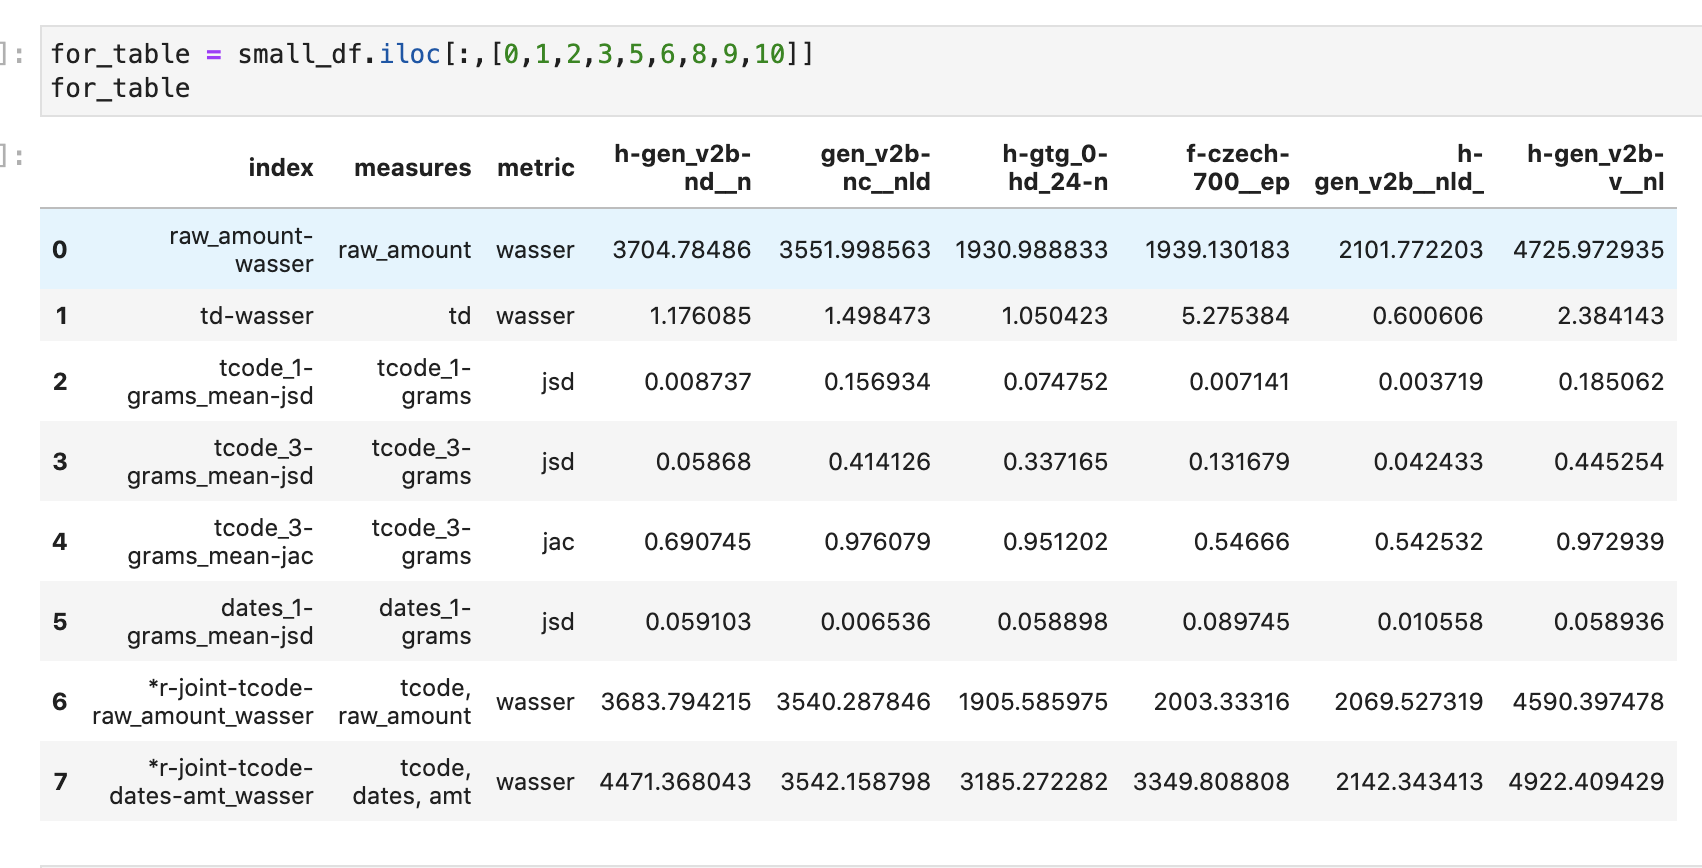

In [37]:
"raw_amount-wasser", "td-wasser", 

('raw_amount-wasser', 'td-wasser')

In [38]:
for_table.set_index('index')

,measures,metric,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17
index,,,,,,,,,,,,,,,,,,,,
raw_amount-wasser,raw_amount,wasser,257.886781,286.622359,249.368302,78.022315,1307.26596,292.015002,116.269945,9359.526931,286.622382,42.565028,61.528453,179.074826,186.306993,64.108142,215.115577,235.883197,238.824506,261.781738
td-wasser,td,wasser,0.35943,1.55132,0.52423,0.53845,1.055556,0.67103,0.58858,0.562704,1.58333,0.25186,0.82216,0.318746,0.73947,0.6018,0.40709,0.70215,0.61131,0.7728
tcode_1-grams_mean-jsd,tcode_1-grams,jsd,0.012914,0.007105,0.017299,0.008813,0.086433,0.024088,0.236815,0.044272,0.071841,0.015011,0.010604,0.01084,0.267163,0.002014,0.055738,0.003897,0.268363,0.004749
tcode_3-grams_mean-jsd,tcode_3-grams,jsd,0.176295,0.236469,0.155487,0.118066,0.296572,0.19367,0.622138,0.237018,0.378434,0.155805,0.135096,0.13451,0.604442,0.111964,0.239768,0.139135,0.613889,0.152624
tcode_3-grams_mean-jac,tcode_3-grams,jac,0.623077,0.639695,0.621235,0.576307,0.853107,0.627281,0.994861,0.803023,0.667205,0.601944,0.599216,0.641874,0.992775,0.58144,0.650491,0.59926,0.996501,0.61599
dates_1-grams_mean-jsd,dates_1-grams,jsd,0.041208,0.152141,0.051195,0.054677,0.086023,0.05695,0.087306,0.046152,0.172306,0.023771,0.048871,0.033889,0.067404,0.047863,0.023132,0.046709,0.080337,0.042646
*r-joint-tcode-raw_amount_wasser,"tcode, raw_amount",wasser,258.324567,286.622359,250.699778,72.102936,1556.398411,297.727792,110.035898,9672.516052,286.622382,40.391657,66.338418,207.27376,213.312216,55.349154,230.140218,240.300772,228.166583,261.731488
*r-joint-tcode-dates-amt_wasser,"tcode, dates, amt",wasser,262.99571,285.221036,251.656527,82.877822,1941.659089,297.107849,131.342361,10459.465573,285.551713,60.116839,81.961957,211.954822,211.291828,87.082522,241.694404,247.904972,231.04603,262.900911


In [39]:
# ds_ord = ['h-gen_v2b__nld_',
# 'h-gen_v2b-nd__n', 
# 'h-gen_v2b-nc__n',
# 'h-gen_v2b-v__nl',
# 'h-gtg_0-hd_24-n',
# 'f-czech-700__ep',]


#  = ['gen_v2b-v__nld_',
#     'gen_v2b__nld_4-',
#        'gen_v2b-nd__nld', 
#     'gen_v2b-v__nld_', 'tg_2-hd_24-nl_4',
       # 'gen_v2b-v__nld_']
    

    
ds_ord =   ['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
 'generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv',
'generated_data/dg_data_new.csv']

In [40]:
for_table.rename(columns=fname_map).set_index('index').iloc[:, 2:][ds_ord]

,generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,generated_data/dg_data_new.csv
index,,,,,,
raw_amount-wasser,42.565028,64.108142,257.886781,235.883197,116.269945,179.074826
td-wasser,0.25186,0.6018,0.35943,0.70215,0.58858,0.318746
tcode_1-grams_mean-jsd,0.015011,0.002014,0.012914,0.003897,0.236815,0.01084
tcode_3-grams_mean-jsd,0.155805,0.111964,0.176295,0.139135,0.622138,0.13451
tcode_3-grams_mean-jac,0.601944,0.58144,0.623077,0.59926,0.994861,0.641874
dates_1-grams_mean-jsd,0.023771,0.047863,0.041208,0.046709,0.087306,0.033889
*r-joint-tcode-raw_amount_wasser,40.391657,55.349154,258.324567,240.300772,110.035898,207.27376
*r-joint-tcode-dates-amt_wasser,60.116839,87.082522,262.99571,247.904972,131.342361,211.954822


In [41]:
ft = for_table.rename(columns=fname_map).set_index('index').iloc[:, 2:][ds_ord].T
ft

index,raw_amount-wasser,td-wasser,tcode_1-grams_mean-jsd,tcode_3-grams_mean-jsd,tcode_3-grams_mean-jac,dates_1-grams_mean-jsd,*r-joint-tcode-raw_amount_wasser,*r-joint-tcode-dates-amt_wasser
generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,42.565028,0.25186,0.015011,0.155805,0.601944,0.023771,40.391657,60.116839
generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,64.108142,0.6018,0.002014,0.111964,0.58144,0.047863,55.349154,87.082522
generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,257.886781,0.35943,0.012914,0.176295,0.623077,0.041208,258.324567,262.99571
generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,235.883197,0.70215,0.003897,0.139135,0.59926,0.046709,240.300772,247.904972
generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,116.269945,0.58858,0.236815,0.622138,0.994861,0.087306,110.035898,131.342361
generated_data/dg_data_new.csv,179.074826,0.318746,0.01084,0.13451,0.641874,0.033889,207.27376,211.954822


In [42]:
use_metrics =  ['raw_amount-wasser', 'td-wasser', 'tcode_1-grams_mean-jsd',
       'tcode_3-grams_mean-jsd', 
       'dates_1-grams_mean-jsd', '*r-joint-tcode-raw_amount_wasser',
       '*r-joint-tcode-dates-amt_wasser']
use_metrics

['raw_amount-wasser',
 'td-wasser',
 'tcode_1-grams_mean-jsd',
 'tcode_3-grams_mean-jsd',
 'dates_1-grams_mean-jsd',
 '*r-joint-tcode-raw_amount_wasser',
 '*r-joint-tcode-dates-amt_wasser']

In [43]:
ft[use_metrics]

index,raw_amount-wasser,td-wasser,tcode_1-grams_mean-jsd,tcode_3-grams_mean-jsd,dates_1-grams_mean-jsd,*r-joint-tcode-raw_amount_wasser,*r-joint-tcode-dates-amt_wasser
generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,42.565028,0.25186,0.015011,0.155805,0.023771,40.391657,60.116839
generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,64.108142,0.6018,0.002014,0.111964,0.047863,55.349154,87.082522
generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,257.886781,0.35943,0.012914,0.176295,0.041208,258.324567,262.99571
generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,235.883197,0.70215,0.003897,0.139135,0.046709,240.300772,247.904972
generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,116.269945,0.58858,0.236815,0.622138,0.087306,110.035898,131.342361
generated_data/dg_data_new.csv,179.074826,0.318746,0.01084,0.13451,0.033889,207.27376,211.954822


In [44]:
!pwd

/Users/kylenickerson/Desktop/verafin_proj_big/ecmlkdd/code_uk_shortseq/metrics-final


In [45]:
def round_to_digits(x, max_digits = 4):
    max_digits -= 1 # leading / trailing 0
    digits_leftof_dot = max(0, np.floor(np.log10(x)) + 1)
    round_to = max(0, max_digits - digits_leftof_dot)
    print("round to", round_to)
    return round(x, int(round_to))

In [46]:
for x in [1000.345, 1234, 9999.352534, 123, 1.36478572, 0.345245449, 0.0054256454]:
    print(x, "\t\t\t" ,np.floor(np.log10(x)) + 1)

1000.345 			 4.0
1234 			 4.0
9999.352534 			 4.0
123 			 3.0
1.36478572 			 1.0
0.345245449 			 0.0
0.0054256454 			 -2.0


In [47]:
for x in [1000.345, 1234, 9999.352534, 123, 1.36478572, 0.345245449, 0.0054256454]:
    print(x, "\t\t\t" ,round_to_digits(x))

round to 0
1000.345 			 1000.0
round to 0
1234 			 1234
round to 0
9999.352534 			 9999.0
round to 0
123 			 123
round to 2.0
1.36478572 			 1.36
round to 3
0.345245449 			 0.345
round to 3
0.0054256454 			 0.005


In [48]:
digits_leftof_dot = max(0, np.floor(np.log10(x)) + 1)
max_digits = 4
round_to = max(0, max_digits - digits_leftof_dot)
round(x, round_to)

0.0054

In [49]:
round(1232.4232, 0)

1232.0

In [50]:
final_table = ft
for col in final_table.columns:
    final_table[col] = final_table[col].apply(round_to_digits)
    
final_table

round to 1.0
round to 1.0
round to 0
round to 0
round to 0
round to 0
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 3
round to 1.0
round to 1.0
round to 0
round to 0
round to 0
round to 0
round to 1.0
round to 1.0
round to 0
round to 0
round to 0
round to 0


index,raw_amount-wasser,td-wasser,tcode_1-grams_mean-jsd,tcode_3-grams_mean-jsd,tcode_3-grams_mean-jac,dates_1-grams_mean-jsd,*r-joint-tcode-raw_amount_wasser,*r-joint-tcode-dates-amt_wasser
generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,42.6,0.252,0.015,0.156,0.602,0.024,40.4,60.1
generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,64.1,0.602,0.002,0.112,0.581,0.048,55.3,87.1
generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,258.0,0.359,0.013,0.176,0.623,0.041,258.0,263.0
generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv,236.0,0.702,0.004,0.139,0.599,0.047,240.0,248.0
generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv,116.0,0.589,0.237,0.622,0.995,0.087,110.0,131.0
generated_data/dg_data_new.csv,179.0,0.319,0.011,0.135,0.642,0.034,207.0,212.0


In [51]:
final_table.index

Index(['generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
       'generated_data/gen_v2b-nd__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
       'generated_data/gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
       'generated_data/gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_20-v2.csv',
       'generated_data/tg_0-hd_24-nl_4-bs_64--len_20.csv',
       'generated_data/dg_data_new.csv'],
      dtype='object')

In [52]:
final_table.reset_index().drop(columns='index')

index,raw_amount-wasser,td-wasser,tcode_1-grams_mean-jsd,tcode_3-grams_mean-jsd,tcode_3-grams_mean-jac,dates_1-grams_mean-jsd,*r-joint-tcode-raw_amount_wasser,*r-joint-tcode-dates-amt_wasser
0,42.6,0.252,0.015,0.156,0.602,0.024,40.4,60.1
1,64.1,0.602,0.002,0.112,0.581,0.048,55.3,87.1
2,258.0,0.359,0.013,0.176,0.623,0.041,258.0,263.0
3,236.0,0.702,0.004,0.139,0.599,0.047,240.0,248.0
4,116.0,0.589,0.237,0.622,0.995,0.087,110.0,131.0
5,179.0,0.319,0.011,0.135,0.642,0.034,207.0,212.0


In [53]:

index	raw_amount-wasser	td-wasser	tcode_1-grams_mean-jsd	tcode_3-grams_mean-jsd	tcode_3-grams_mean-jac	dates_1-grams_mean-jsd	*r-joint-tcode-raw_amount_wasser	*r-joint-tcode-dates-amt_wasser
0	42.6	0.252	0.015	0.156	0.602	0.024	40.4	60.1
1	64.1	0.602	0.002	0.112	0.581	0.048	55.3	87.1
2	258.0	0.359	0.013	0.176	0.623	0.041	258.0	263.0
3	236.0	0.702	0.004	0.139	0.599	0.047	240.0	248.0
4	116.0	0.589	0.237	0.622	0.995	0.087	110.0	131.0
5	179.0	0.319	0.011	0.135	0.642	0.034	207.0	212.0

SyntaxError: invalid syntax (3071160923.py, line 1)

In [ ]:
final_table.to_clipboard()

# * Almost done table

In [ ]:
small_df = final_rank_df[final_rank_df["index"].apply(lambda x: x in filter_list)].reset_index(drop=True)
small_df.columns =  [shortname(lbl) for lbl in small_df]
small_df

In [ ]:
small_df.iloc[:,[0,1,2,3,5,6,8,9,10]]

In [ ]:
small_df.iloc[:,[3,5,6,8,9,10]].rank(axis=1)

# Select single 'best'  
Here we are considering the 'best' as the dataset with the highest average rank on important metrics

In [ ]:
x_labels = [fname_map[x].replace("generated_data/", "") for x in value_cols]
short_labels_2 = [x[10:30] + "--" + x[50:66] for x in x_labels]
short_labels_2

In [ ]:
small_df

In [ ]:
len(small_df.columns)

In [ ]:
[fname_map[x].split('/')[1] for x in value_cols]

In [ ]:
small_df.columns

In [ ]:
small_df[sel_cols]

In [ ]:
len(sel_cols)

In [ ]:
small_df[sel_cols].values.shape

In [ ]:
small_df[sel_cols].mean(axis=0)

In [ ]:
# result_df = small_df[value_cols].mean(axis=0).reset_index() 
result_df = small_df[sel_cols].mean(axis=0).reset_index() 
result_df.rename(columns={0:"ave_rank"}, inplace=True)
# result_df["filename"] = result_df["index"].apply(lambda x: fname_map[x].split("/")[1])

# result_df["short_labels_2"] = short_labels_2
result_df

In [ ]:
# best_col = result_df.iloc[result_df[0].argmin()]["index"]
best_col = result_df.iloc[result_df["ave_rank"].argmin()]["index"]

print("Best result is from:", fname_map[best_col])

In [ ]:
result_df["filename"] = result_df["index"].apply(lambda x: fname_map[x].split("/")[1])
result_df.sort_values(by="ave_rank")

# New

In [ ]:
full_vals_df = vals_df.copy()
full_vals_df

In [ ]:
true_full_vals_df = full_vals_df.copy()
true_full_vals_df

In [ ]:
vals_df[value_cols]

In [ ]:
vals_df = vals_df[value_cols].copy()
vals_df

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
scaled_vals_df = pd.DataFrame.from_records(scale(vals_df.to_numpy(), axis=1))
scaled_vals_df

In [ ]:
scaled_vals_df.describe()

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.matshow(scaled_vals_df)

In [ ]:
plt.matshow(scaled_vals_df > 2.0)
plt.xlabel(value_cols)

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df > 2.0, linewidths=0.1)

In [ ]:
vals_df

## Interesting plots

#### Score outliers

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df > 2.0, linewidths=0.1, xticklabels=x_labels, yticklabels=full_vals_df["index"])
plt.xticks(rotation=270)
plt.title(f"Score significantly > average")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(scaled_vals_df < -2.0, linewidths=0.1, xticklabels=x_labels, yticklabels=full_vals_df["index"])
plt.xticks(rotation=270)
plt.title(f"Score significantly < average")
plt.show()

#### Visualize ranks

In [ ]:
final_rank_df

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(final_rank_df[value_cols], linewidths=0.1, xticklabels=x_labels, yticklabels=full_vals_df["index"])
plt.xticks(rotation=270)
plt.title(f"Raw ranks")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(final_rank_df[value_cols], linewidths=0.1, xticklabels=x_labels, 
            yticklabels=full_vals_df["index"], cmap=sns.color_palette("vlag", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Raw ranks")
plt.show()

#### Block ranks  
Groups ranks as: Top-k, bottom-k and remaining

In [ ]:
k = 3

In [ ]:
len(value_cols) - k

In [ ]:
block_ranks = final_rank_df[value_cols].copy()
# block_ranks[value_cols][block_ranks[value_cols] <= 3] = 100
# block_ranks[]

best_vals = block_ranks < k
worst_vals = block_ranks >= len(value_cols) - k
mid_vals = ~np.logical_or(best_vals, worst_vals)


block_ranks[best_vals] = 100
block_ranks[worst_vals] = 0
block_ranks[mid_vals] = 50

block_ranks

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(block_ranks, linewidths=0.1, xticklabels=x_labels, 
            yticklabels=full_vals_df["index"], cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Block ranks - Bigger is better")
plt.show()

In [ ]:
x = (block_ranks > 50.0).sum()
for row in x.iteritems():
    break
    
row

In [ ]:
fname_map

get_short_fname = lambda x: fname_map[x].split("/")[1][:12]

l = [(get_short_fname(row[0]), row[1]) for row in x.iteritems()]
df = pd.DataFrame.from_records(l, columns=["fname", f"Times in top {k}"])
df.sort_values(by=f"Times in top {k}", ascending=False)

## Correlations

In [ ]:
full_vals_df[value_cols]

In [ ]:
plt.figure(figsize=(10,10))
cor = np.corrcoef(scaled_vals_df)
sns.heatmap(cor, cmap=sns.color_palette("vlag", as_cmap=True))


In [ ]:
cor

In [ ]:
zero_var_cols = scaled_vals_df.transpose().std() == 0.0

In [ ]:
plt.figure(figsize=(10,10))
cor = np.corrcoef(scaled_vals_df[~zero_var_cols])
sns.heatmap(cor, cmap=sns.color_palette("vlag", as_cmap=True), 
            xticklabels=full_vals_df["index"][~zero_var_cols], yticklabels=full_vals_df["index"][~zero_var_cols])

## Cluster

In [ ]:
scaled_vals_df

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#### points are metrics

In [ ]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df)
pcs.shape

In [ ]:
plt.scatter(pcs[:,0], pcs[:,1])
plt.title("Points are metrics")
plt.show()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(scaled_vals_df)
tsne.shape

In [ ]:
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("Points are metrics")
plt.show()

#### points are datasets

In [ ]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df.transpose())
pcs.shape

In [ ]:
plt.scatter(pcs[:,0], pcs[:,1])
plt.title("Points are datasets")
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=2).fit_transform(scaled_vals_df.transpose())
tsne.shape

In [ ]:
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("Points are datasets")
plt.show()

### Color

#### points are metrics

In [ ]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df)
pcs.shape

In [ ]:
# plt.scatter(pcs[:,0], pcs[:,1], c=np.argmax(scaled_vals_df.to_numpy(), axis=1))
plt.scatter(pcs[:,0], pcs[:,1], c=np.argmin(scaled_vals_df.to_numpy(), axis=1))
plt.title("Points are metrics. Color indicates best dataset")
plt.show()

In [ ]:
tsne = TSNE(n_components=2).fit_transform(scaled_vals_df)
tsne.shape

In [ ]:
plt.scatter(tsne[:,0], tsne[:,1], c=np.argmax(scaled_vals_df.to_numpy(), axis=1))
plt.title("Points are metrics")
plt.show()

In [ ]:
len(set(np.argmax(scaled_vals_df.to_numpy(), axis=1)))

#### points are datasets

In [ ]:
result_df

In [ ]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df.transpose())
pcs.shape

In [ ]:
# plt.scatter(pcs[:,0], pcs[:,1], c=result_df.ave_rank)
plt.scatter(pcs[:,0] + np.random.normal(scale=0.2, size=pcs[:,0].shape), 
            pcs[:,1] + np.random.normal(scale=0.2, size=pcs[:,0].shape), c=result_df.ave_rank)
plt.title("Points are datasets. Color by average rank")
plt.show()

In [ ]:
best_on_each_metric = np.argmax(scaled_vals_df.to_numpy(), axis=1)
colors = np.array([sum(best_on_each_metric==x) for x in range(len(result_df)) ])
colors

In [ ]:

plt.scatter(pcs[:,0] + np.random.normal(scale=0.2, size=pcs[:,0].shape), 
            pcs[:,1] + np.random.normal(scale=0.2, size=pcs[:,0].shape), c=colors)
plt.title("Points are datasets. Color by number of metrics best on")
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=2).fit_transform(scaled_vals_df.transpose())
tsne.shape

In [ ]:
plt.scatter(tsne[:,0], tsne[:,1], c=result_df.ave_rank)
plt.title("Points are datasets. Color by average rank")
plt.show()

In [ ]:

plt.scatter(tsne[:,0] + np.random.normal(scale=0.2, size=pcs[:,0].shape), 
            tsne[:,1] + np.random.normal(scale=0.2, size=pcs[:,0].shape), c=colors)
plt.title("Points are datasets. Color by number of metrics best on")

plt.show()

### Plotly

In [ ]:
import plotly.graph_objects as go

In [ ]:
final_rank_df

#### points are metrics

In [ ]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df)
pcs.shape

In [ ]:
tsne = TSNE(n_components=2).fit_transform(scaled_vals_df)
tsne.shape

In [ ]:
fname_map

In [ ]:

parse_k = lambda x: int(x.split("_")[-1])
parse_v = lambda x: x.split("/")[-1][:10]

mini_fname_map = dict([ (parse_k(k), parse_v(v)) for k, v in fname_map.items() ])
mini_fname_map

In [ ]:
d = {
    "pc0": pcs[:,0],
    "pc1": pcs[:,1],
    "tsne0": tsne[:,0],
    "tsne1": tsne[:,1],
    "metric": final_rank_df["index"],
    "best_dataset_no": np.argmin(scaled_vals_df.to_numpy(), axis=1),
    "measures": final_rank_df.measures,
    "base_metric": final_rank_df.metric,
}

plot_df_metrics = pd.DataFrame.from_dict(d)


plot_df_metrics["best_dataset"] = plot_df_metrics["best_dataset_no"].apply(lambda x: mini_fname_map[x])
plot_df_metrics["text"] = plot_df_metrics['metric'] + "--" + plot_df_metrics['best_dataset'].astype(str)

plot_df_metrics

In [ ]:
uniq_models = plot_df_metrics.best_dataset.unique()

get_model_no = lambda x: list(uniq_models).index(x)

plot_df_metrics["best_model_no"] = plot_df_metrics.best_dataset.apply(get_model_no)
plot_df_metrics

In [ ]:
fig = go.Figure(data=go.Scatter(x=plot_df_metrics['pc0'],
                                y=plot_df_metrics['pc1'],
                                mode='markers',
                                marker_color=plot_df_metrics['best_dataset_no'],
                                text=plot_df_metrics["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
)

# fig.update_layout(title='Population of USA States')
fig.show()

In [ ]:
fig = go.Figure(data=go.Scatter(x=plot_df_metrics['pc0'],
                                y=plot_df_metrics['pc1'],
                                mode='markers',
                                marker_color=plot_df_metrics['best_model_no'],
                                text=plot_df_metrics["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title = "Points are metrics. Color is model number"
)

# fig.update_layout(title='Population of USA States')
fig.show()

#### points are datasets

In [ ]:
scaled_vals_df.transpose()

In [ ]:
pcs = PCA(n_components=2).fit_transform(scaled_vals_df.transpose())
pcs.shape

In [ ]:
tsne = TSNE(n_components=2, perplexity=2).fit_transform(scaled_vals_df.transpose())
tsne.shape

In [ ]:
d = {
    "pc0": pcs[:,0],
    "pc1": pcs[:,1],
    "tsne0": tsne[:,0],
    "tsne1": tsne[:,1],
}


In [ ]:
plot_df_datasets = pd.merge(result_df, pd.DataFrame.from_dict(d), left_index=True, right_index=True).drop(columns=["index"])

best_on_each_metric = np.argmin(scaled_vals_df.to_numpy(), axis=1)
plot_df_datasets["best_count"] = np.array([sum(best_on_each_metric==x) for x in range(len(result_df)) ])
plot_df_datasets["best_prop"] = plot_df_datasets["best_count"] / sum(plot_df_datasets["best_count"])

worst_on_each_metric = np.argmax(scaled_vals_df.to_numpy(), axis=1)
plot_df_datasets["worst_count"] = np.array([sum(worst_on_each_metric==x) for x in range(len(result_df)) ])
plot_df_datasets["worst_prop"] = plot_df_datasets["worst_count"] / sum(plot_df_datasets["worst_count"])

plot_df_datasets

In [ ]:
plot_df_datasets["shortname"] = plot_df_datasets.filename.apply(lambda x: x[:6])
plot_df_datasets

In [ ]:
text_parts = []
text_parts.append(plot_df_datasets.shortname)
text_parts.append(plot_df_datasets.best_count.astype(str) )
text_parts.append(plot_df_datasets.worst_count.astype(str) )
text_parts.append(plot_df_datasets.ave_rank.round(1).astype(str) )

s = ""
for part in text_parts:
    s += part + "__"

plot_df_datasets["text"] = s
plot_df_datasets

In [ ]:
fig = go.Figure(data=go.Scatter(x=plot_df_datasets['pc0'],
                                y=plot_df_datasets['pc1'],
                                mode='markers',
#                                 marker_color=plot_df_datasets['ave_rank'],
                                marker=dict(color= plot_df_datasets['ave_rank'], 
                                  colorscale='Viridis', size=10, colorbar=dict(thickness=20)),
                                text=plot_df_datasets["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title = "Points are datasets. Color is ave rank"
)

# fig.update_layout(title='Population of USA States')
fig.show()

In [ ]:
fig = go.Figure(data=go.Scatter(x=plot_df_datasets['tsne0'],
                                y=plot_df_datasets['tsne1'],
                                mode='markers',
#                                 marker_color=plot_df_datasets['ave_rank'],
                                marker=dict(color= plot_df_datasets['ave_rank'], 
                                  colorscale='Viridis', size=10, colorbar=dict(thickness=20)),
                                text=plot_df_datasets["text"])) # hover text goes here


fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title = "Points are datasets. Color is ave rank"
)

# fig.update_layout(title='Population of USA States')
fig.show()

In [ ]:
plot_df_datasets.filename[1]

### Really cluster

In [ ]:
from sklearn import cluster

In [ ]:
cl = cluster.KMeans(n_clusters=5)


In [ ]:
scaled_vals_df

In [ ]:
cl.fit(scaled_vals_df)

In [ ]:
cl.labels_

In [ ]:
cl.labels_==0

In [ ]:
# xticklabels=full_vals_df["index"][~zero_var_cols], yticklabels=full_vals_df["index"][~zero_var_cols]

In [ ]:
full_vals_df["index"][cl.labels_==0]

In [ ]:
for i in range(max(cl.labels_)+1):
    print(i)
    display(full_vals_df["index"][cl.labels_==i])
    print("\n\n")

In [ ]:
from sklearn import metrics

metric_list = {
       "sil" : metrics.silhouette_score,
        "chs": metrics.calinski_harabasz_score,
        "dbi": metrics.davies_bouldin_score 
}



all_res = {}
all_models = {}
for k in range(3, 25):
    
    res = {}
    all_res[k] = res
    
    kmeans_model = cluster.KMeans(n_clusters=k).fit(scaled_vals_df)
    labels = kmeans_model.labels_
    
    all_models[k] = kmeans_model
    
    for name, fn in metric_list.items():
        
        res[name] = fn(scaled_vals_df, labels)
        
        

In [ ]:
df = pd.DataFrame.from_dict(all_res)
df

In [ ]:
df == df.max(axis=1)

In [ ]:
vals = df.iloc
np.argmax(vals[:2,:].to_numpy(), axis=1)

In [ ]:
vals = df.iloc
np.argmin(vals[2:,:].to_numpy(), axis=1)

In [ ]:
df.to_numpy()

In [ ]:
plt.plot(df.iloc[0,:])

In [ ]:
plt.plot(df.iloc[1,:])

In [ ]:
plt.plot(df.iloc[2,:])

In [ ]:
!jupyter --version

In [ ]:
k = 15

cl = cluster.KMeans(n_clusters=15).fit(scaled_vals_df)

for i in range(max(cl.labels_)+1):
    print(i)
    display(full_vals_df["index"][cl.labels_==i])
    print("\n\n")

### next

In [ ]:
final_rank_df.measures.unique()

In [ ]:
final_rank_df.metric.unique()

In [ ]:
df_merged

In [ ]:
non_name_rows = ~(df_merged.measures == "name")
non_coverage_rows = df_merged.metric.apply(lambda x: "coverage" not in x)

In [ ]:
np.logical_and(non_name_rows, non_coverage_rows).sum()

In [ ]:
df_merged[np.logical_and(non_name_rows, non_coverage_rows)]

### next 2

In [ ]:
df_merged[value_cols][non_name_rows]

In [ ]:
df_merged[value_cols][non_name_rows].describe(percentiles=[.10, .5, .9])

In [ ]:
rand_vals = pd.DataFrame.from_records(np.random.random(size=(10,10)))
rand_vals.describe()

# Narrow down what to include

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
df_merged.measures.unique()

In [ ]:
non_name_rows = ~(df_merged.measures == "name")
date_metrics = df_merged.measures.apply(lambda x: "date" in x)
one_gram_metrics = df_merged.measures.apply(lambda x: "1-grams" in x)
three_grams_metrics = df_merged.measures.apply(lambda x: "3-grams" in x)
joint_metrics = df_merged.measures.apply(lambda x: "," in x)

In [ ]:
homogeneous_rows = df_merged[value_cols].T.describe().T.unique == 1.0
homogeneous_rows

In [ ]:
useful_val_rows = np.logical_and(non_name_rows, ~homogeneous_rows)
useful_val_rows

In [ ]:
inds = np.logical_and(non_name_rows, date_metrics)
inds = np.logical_and(inds, ~homogeneous_rows)

df_merged[inds]

In [ ]:
df_merged.metric.unique()

### herr

In [ ]:
combo_metric_setup = {"big_quality": ['ks', 'wasser', 'jsd', 'jac'],
 "small_quality1": ['ks', 'jsd'],
 "small_quality2": ['wasser', 'jsd'],
 "coverage_big": ['jac', 'coverage_g'],
 "coverage_small": ['coverage_g'] }

In [ ]:
np.ones(len(df_merged), dtype=bool)

In [ ]:
combo_metric_rows = {}

for k, v in combo_metric_setup.items():
    
    inds = np.zeros(len(df_merged), dtype=bool)
    
    for field in v:
        
        new_inds = df_merged.metric.apply(lambda x: field in x)
        inds = np.logical_or(inds, new_inds)
        
        
    combo_metric_rows[k] = inds
    
    

combo_measures_rows = {}
for k in ['date_metrics', 'one_gram_metrics', 'three_grams_metrics', 'joint_metrics']:
    combo_measures_rows[k] = eval(k)
    
# combo_metric_rows

In [ ]:
for i, rows in enumerate([date_metrics, one_gram_metrics, three_grams_metrics, joint_metrics]):
    
    inds = np.logical_and(useful_val_rows, rows)
    
    break

In [ ]:
df_merged[non_name_rows][value_cols].astype(float).describe()

In [ ]:
def plot_rank_and_block(sub_df_merged, k=3, xlabels = None, second_plot = 'block', second_plot_opts = ['b', 'rs', 'ss', 'ns'], max_show_x=15):
    
    
    new_rank_df = sub_df_merged.rank(axis=1)
    

    fig, ax = plt.subplots(1,2 ,figsize=(18, 10))
    

    if xlabels is None:
        short_xlabels = [x[:12] for x in x_labels]
    else:
        short_xlabels = xlabels

        
    colnames, ave_vals  = zip(*dict(new_rank_df.mean()).items())

    sort_inds = np.argsort(ave_vals)
    sorted_colnames = np.array(colnames)[sort_inds]
    short_xlabels = np.array(short_xlabels)[sort_inds]


    sns.heatmap(new_rank_df[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0])

    ax[0].set_title(f"Ranks - Smaller is better")

    
    if second_plot in ['block', 'b']:
        
        block_ranks = new_rank_df.copy()

        n_val_cols = new_rank_df.shape[1]
        best_vals = block_ranks <= k
        worst_vals = block_ranks > n_val_cols - k
        mid_vals = ~np.logical_or(best_vals, worst_vals)


        block_ranks[best_vals] = 100
        block_ranks[worst_vals] = 0
        block_ranks[mid_vals] = 50
        
        colnames, ave_vals  = zip(*dict(block_ranks.mean()).items())
        
        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]
        short_xlabels = np.array(short_xlabels)[sort_inds]

        sns.heatmap(block_ranks[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Block ranks - Bigger is better")

    elif second_plot == 'rs': # raw score
        
        colnames, ave_vals  = zip(*dict(sub_df_merged.mean()).items())
        
        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]
        short_xlabels = np.array(short_xlabels)[sort_inds]

        sns.heatmap(sub_df_merged[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Raw score - Smaller is better")
        
        
    elif second_plot == 'ss': # scaled scores
            
        scaled_df = sub_df_merged.copy()
        
        for i in range(len(scaled_df)):
            if sum(np.abs(scaled_df.iloc[i])) > 0:
                scaled_df.iloc[i] /= sum(np.abs(scaled_df.iloc[i]))
        
        
        colnames, ave_vals  = zip(*dict(scaled_df.mean()).items())

        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]        
        short_xlabels = np.array(short_xlabels)[sort_inds]
        
        
        sns.heatmap(scaled_df[sorted_colnames].iloc[:,:max_show_x], linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Scaled score (row sums to 1) - Smaller is better")
        
        
        

        
    elif second_plot == 'ns': # Normalized scores - 0 mean, 1 sd
        
        colnames, ave_vals  = zip(*dict(sub_df_merged.mean()).items())

        sort_inds = np.argsort(ave_vals)
        sorted_colnames = np.array(colnames)[sort_inds]        
        short_xlabels = np.array(short_xlabels)[sort_inds]
        
        sns.heatmap(scale(sub_df_merged[sorted_colnames], axis=1), linewidths=0.1, xticklabels=short_xlabels[:max_show_x], 
                    yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

        ax[1].set_title(f"Normalized score - Smaller is better")
        
        
    # plt.xticks(rotation=270)
    plt.tight_layout()
    plt.show()


In [ ]:
block_ranks

In [ ]:
block_ranks.mean()

In [ ]:
colnames, ave_vals  = zip(*dict(block_ranks.mean()).items())
colnames, ave_vals

In [ ]:
sorted_colnames = np.array(colnames)[np.argsort(ave_vals)]
sorted_colnames

In [ ]:
a = np.arange(9).reshape((3,3))
a

In [ ]:
scale(a, axis=1)

In [ ]:
short_xlabels = [x[:12] for x in x_labels]

In [ ]:
def use_dataset_1(ds_name):
    for x in ["v2a-", "b_", "v2c-", "mostly", "sdv", "timegan"]:
        if x in ds_name:
            return True
        
    return False


def use_dataset_2(ds_name):
    for x in ["v2b-", "b_", "mostly", "sdv", "timegan"]:
        if x in ds_name:
            return True
        
    return False



def use_dataset_paper(ds_name):
    for x in ["v2b-", "v2a-", "b_", 'dg', "timegan", "tg", "sdv", "f-cz"]:
        if x in ds_name:
            return True
        
    return False


def use_dataset_v2b_base(ds_name):

    if "_v2b_" in ds_name and not 'h-' in ds_name and not 't-' in ds_name:
        return True
        
    return False


def use_only_tg(ds_name):

    if "tg" in ds_name and not 'h-' in ds_name and not 't-' in ds_name:
        return True
        
    return False


def useall(x): return True

cond = lambda x: (x[1] != '-' and '.csv' in x and "__" in x and '4-dm_128-nh_2-' in x and 'lwi_0-bs_64--vf1-len_100-v2' in x and (not x[:2] in ['t-','h-'])) 
# or "v2a" in x

# use_dataset = use_dataset_paper
# use_dataset = use_dataset_2
use_dataset = use_dataset_v2b_base
use_dataset = cond
use_dataset = use_only_tg
use_dataset = useall

In [ ]:
[x for x in x_labels if cond(x)];

do cross prod of metric, meseaures below

In [ ]:

def clean_fname(fname):
    for x in ['gen_v2b__n', 'i_0-dr_0__1-opt_adam-', 'i_1-dr_0__1-opt_adam-']:
        fname = fname.replace(x, '')
    if not fname[0] in ['h', 't']:
        fname = 'f-' + fname # full
    fname = fname.replace('moredate', 'mdt')
    fname = fname.replace('lwi_0', 'lwi_bas')
    return fname

[clean_fname(x) for x in x_labels];

In [ ]:
common_names = [x.split('--')[0][2:] if x[0] in ['h','t'] else x.split('--')[0] for x in x_labels]
common_names;

In [ ]:
x_labels

In [ ]:
len(x_labels)

In [ ]:
result_df

In [ ]:
# col_inds = [use_dataset(x) for x in short_xlabels]
col_inds = [use_dataset(x) for x in x_labels]
use_val_cols = np.array(value_cols)[col_inds].tolist()
# use_xlabels = np.array([clean_fname(x) for x in x_labels])[col_inds]
use_xlabels = np.array([x for x in common_names])[col_inds]

max_show_x = 12

new_result_df = result_df[col_inds].copy()


for k, rows in list(combo_metric_rows.items()) + list(combo_measures_rows.items() ):
    
    inds = np.logical_and(useful_val_rows, rows)
    
    
    
    sub_df_merged = df_merged[inds][use_val_cols].astype(float)
    new_rank_df = sub_df_merged.rank(axis=1)

    
    new_result_df[k] = new_rank_df.mean().to_list()
    
    print("*****", k, "*********")
    
    plot_rank_and_block(sub_df_merged, xlabels = use_xlabels, second_plot="ss", max_show_x = max_show_x)
    
    print("Breaking...")
    break 
    
    
new_result_df#.drop(columns=['index'])

In [ ]:
new_result_df.sort_values("ave_rank")

In [ ]:

"h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv"



In [ ]:
def show_full_df(df):
    with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
        display(df)

In [ ]:
['gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'gen_v2b-nc__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'gen_v2b-v__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'tg_0-hd_24-nl_4-bs_64--len_80.csv'
]

In [ ]:
show_full_df(new_result_df.sort_values("big_quality"))

In [ ]:
9

In [ ]:
new_result_df["f_prefix"] = new_result_df.filename.apply(lambda x: x.split("nld_")[0].split("-hd_")[0]) 

In [ ]:
!pwd

In [ ]:
'h-gen_v2a__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv'
'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv'
'gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_100-v2.csv'



In [ ]:
cols = "ave_rank	filename	short_labels_2	big_quality	f_prefix".split()
v2b = new_result_df.filename.apply(lambda x: 'v2b' in x)
show_full_df(new_result_df[cols].sort_values(["f_prefix", "big_quality"]).groupby("f_prefix").head(1))

In [ ]:
v2b = new_result_df.filename.apply(lambda x: 'v2b' in x)
show_full_df(new_result_df[v2b].sort_values(["f_prefix", "big_quality"]).groupby("f_prefix").head(1))

In [ ]:
v2b = new_result_df.filename.apply(lambda x: 'v2b' in x)
show_full_df(new_result_df[~v2b].sort_values("big_quality"))

In [ ]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", 25):
    display(new_result_df.sort_values("ave_rank"))

In [ ]:
new_result_df["fname"] = new_result_df["index"].apply(lambda x: fname_map[x])
new_result_df

In [ ]:
fname_map

In [ ]:
# print("*"*50, "\n"*8, "*"*50, "\nCross of conditions", "\n"*5)


for k_mea, mea_rows in combo_measures_rows.items():
    
    for k_met, met_rows in combo_metric_rows.items():

        inds = np.logical_and(useful_val_rows, mea_rows)
        inds = np.logical_and(inds, met_rows)

        k = f"{k_mea}--{k_met}"
        

        sub_df_merged = df_merged[inds][use_val_cols].astype(float)
        new_rank_df = sub_df_merged.rank(axis=1)


        new_result_df[k] = new_rank_df.mean().to_list()

        print("*****", k, "*********")

        plot_rank_and_block(sub_df_merged, xlabels = use_xlabels, second_plot="ss")



    
    

In [ ]:
x_labels[0].split("--")[0] + ".pickle"

In [ ]:
new_result_df = new_result_df.reset_index()

In [ ]:
x = new_result_df.filename[2]
x

In [ ]:
x.split("__")

In [ ]:
x.replace("gen_v2b__", "").split("--")[0].replace('__', '.').split('-')

In [ ]:
[y.split('_') for y in x.replace("gen_v2b__", "").split("--")[0].replace('__', '.').split('-')]

In [ ]:
parse_fname = lambda x: dict([try_parse_split(y) for y in x.replace("gen_v2b__", "").split("--")[0].replace('__', '.').split('-')])

In [ ]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(new_result_df.sort_values("ave_rank"))

In [ ]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(new_result_df.sort_values("big_quality"))

In [ ]:
import pickle 

root_dir = "../banksformer_v2b/training_history/"


final_fits = []
condition = root_dir.split("/")[1]
names = []
fit_times = []

for csv_fname in x_labels:
    
    # if ".pickle" in fname:
    pickle_fname = csv_fname.split("--")[0][4:] + ".pickle"
        
    with open(f"{root_dir}{pickle_fname}", "rb") as f:
        data =  pickle.load(f) 

    final_fits.append(data["val_loss"][-1].numpy())
    # names.append(fname.split(".")[0])
    names.append(pickle_fname.split(".")[0])
    
    try:
        fit_times.append(data['fit_time'])
    except:
        print("No fit time for", pickle_fname)
        fit_times.append(-1)

            
loss_types = [x.split("-")[-2].split("_")[1] for x in names]


In [ ]:
loss_types

In [ ]:
data['fit_time']

In [ ]:
result_df

In [ ]:
names

In [ ]:
rdf2 = result_df.drop(columns=['filename', 'short_labels_2'])
 
    
for f in ['final_fits', 'names', 'loss_types', 'fit_times']:
    rdf2[f] = eval(f)


rdf2

In [ ]:
rdf2.loss_types.factorize()

In [ ]:
plt.scatter(rdf2.ave_rank, rdf2.final_fits, c=rdf2.loss_types.factorize()[0])
plt.colorbar()
plt.xlabel("Ave rank")
plt.ylabel("Val loss")
plt.show()

In [ ]:
plt.scatter(rdf2.ave_rank, rdf2.fit_times, c=rdf2.loss_types.factorize()[0])
plt.colorbar()
plt.xlabel("Ave rank")
plt.ylabel("Fit time")
plt.show()

In [ ]:
x_labels[0].split("--")[0][4:] + ".pickle" in os.listdir("../banksformer_v2b/training_history/")

In [ ]:
x_labels[0].split("--")[0][4:] + ".pickle"

In [ ]:
fname

In [ ]:
k = 3

In [ ]:
block_ranks = new_rank_df.copy()

best_vals = block_ranks <= k
worst_vals = block_ranks > len(value_cols) - k
mid_vals = ~np.logical_or(best_vals, worst_vals)


block_ranks[best_vals] = 100
block_ranks[worst_vals] = 0
block_ranks[mid_vals] = 50

block_ranks

In [ ]:
full_vals_df["index"][inds]

In [ ]:
plt.figure(figsize=(10,10))
short_xlabels = [x[:12] for x in x_labels]
sns.heatmap(block_ranks, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Block ranks - Bigger is better")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
short_xlabels = [x[:12] for x in x_labels]
sns.heatmap(new_rank_df, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True))
plt.xticks(rotation=270)
plt.title(f"Ranks - Smaller is better")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2 ,figsize=(18, 10))

short_xlabels = [x[:12] for x in x_labels]




sns.heatmap(new_rank_df, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1])

ax[0].set_title(f"Ranks - Smaller is better")


sns.heatmap(block_ranks, linewidths=0.1, xticklabels=short_xlabels, 
            yticklabels=full_vals_df["index"][inds], cmap=sns.color_palette("vlag_r", as_cmap=True), ax=ax[0])

ax[1].set_title(f"Block ranks - Bigger is better")

# plt.xticks(rotation=270)
plt.tight_layout()
plt.show()